In [49]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/voting_VA.csv")

print(df.head())
print(df.isnull().sum())

   Unnamed: 0  year     state state_po county_name  county_fips        office  \
0       11161  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
1       11162  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
2       11163  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
3       11164  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
4       11165  2000  VIRGINIA       VA   ALBEMARLE        51003  US PRESIDENT   

        candidate       party  candidatevotes  totalvotes   version   mode  
0         AL GORE    DEMOCRAT            5092       11925  20220315  TOTAL  
1  GEORGE W. BUSH  REPUBLICAN            6352       11925  20220315  TOTAL  
2     RALPH NADER       GREEN             220       11925  20220315  TOTAL  
3           OTHER       OTHER             261       11925  20220315  TOTAL  
4         AL GORE    DEMOCRAT           16255       36846  20220315  TOTAL  
Unnamed: 0        0
year              0
state      

In [50]:
# Remove the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Check unique values for certain columns to ensure consistency
print(df['state'].unique())  # Should only contain "VIRGINIA"
print(df['state_po'].unique())  # Should only contain "VA"
print(df['office'].unique())  # Should only contain "US PRESIDENT"
print(df['mode'].unique())  # Check if any action is needed

['VIRGINIA']
['VA']
['US PRESIDENT']
['TOTAL' 'ABSENTEE' 'ELECTION DAY' 'PROVISIONAL']


In [51]:
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: object

In [52]:
# If we're interested in overall voting results without differentiating between the modes:
# df_total = df[df['mode'] == 'TOTAL']
# df_total.to_csv("data/clean_total_voting_VA.csv", index=False) 

# Otherwise, we can keep all of the modes of voting and use them as features
# in our models
df['mode'] = df['mode'].astype('category')
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: category
Categories (4, object): ['ABSENTEE', 'ELECTION DAY', 'PROVISIONAL', 'TOTAL']

In [53]:
# Provides a dataframe where the modes aggregates all individual records across different voting modes 
# into a single record per candidate per county per election year. 

df_aggregated = df.groupby(['year', 'county_name', 'county_fips', 'candidate', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'  # Assuming totalvotes is the same across all modes, otherwise sum might be needed
}).reset_index()

df_aggregated.head()

,year,county_name,county_fips,candidate,party,candidatevotes,totalvotes
0,2000,ACCOMACK,51001,AL GORE,DEMOCRAT,5092,11925
1,2000,ACCOMACK,51001,GEORGE W. BUSH,REPUBLICAN,6352,11925
2,2000,ACCOMACK,51001,OTHER,OTHER,261,11925
3,2000,ACCOMACK,51001,RALPH NADER,GREEN,220,11925
4,2000,ALBEMARLE,51003,AL GORE,DEMOCRAT,16255,36846


In [54]:
import pandas as pd
#removing candidates column (unimportant)
df_real = df_aggregated.drop('candidate', axis=1)
#removing third parties (also unimportant)
df_real = df_real[~df_real['party'].isin(['OTHER', 'GREEN'])]
#finding net total votes
df_real['net_total'] = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes'])['candidatevotes'].transform(lambda x: x.iloc[1] - x.iloc[0])

# merging columns
df_real = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes', 'net_total']).agg({'party': ', '.join}).reset_index()
df_real['winner'] = df_real['net_total'].apply(lambda x: 'REPUBLICAN' if x > 0 else 'DEMOCRAT')
#dropping some more columns
df_real = df_real.drop(['party', 'totalvotes'], axis=1)
df_final = df_real[['year', 'county_name', 'county_fips','net_total', 'winner']]
df_final.head()

,year,county_name,county_fips,net_total,winner
0,2000,ACCOMACK,51001,1260,REPUBLICAN
1,2000,ALBEMARLE,51003,2036,REPUBLICAN
2,2000,ALEXANDRIA,51510,-14590,DEMOCRAT
3,2000,ALLEGHANY,51005,594,REPUBLICAN
4,2000,AMELIA,51007,1193,REPUBLICAN


In [55]:
df_melt = pd.read_csv("data/df_melt.csv")

year_mapping = {
    2000: 2000,
    2004: 2000,
    2008: 125,
    2012: 125,
    2016: 195,
    2020: 195
}
df_final['melt_year'] = df_final['year'].map(year_mapping)

# Convert columns to the same data type before merging
df_final['melt_year'] = df_final['melt_year'].astype(str)
df_final['county_fips'] = df_final['county_fips'].astype(str)
df_melt['YEAR'] = df_melt['YEAR'].astype(str)
df_melt['FIPS'] = df_melt['FIPS'].astype(str)

merged_df = pd.merge(df_final, df_melt, left_on=['melt_year', 'county_fips'], right_on=['YEAR', 'FIPS'])

columns_to_drop = ['YEAR', 'FIPS', 'melt_year']
df_updated = merged_df.drop(columns=columns_to_drop)

print(df_updated.head())

   year county_name county_fips  net_total      winner     AV0AA     B78AA  \
0  2000    ACCOMACK       51001       1260  REPUBLICAN   38305.0   38305.0   
1  2004    ACCOMACK       51001      -2208    DEMOCRAT   38305.0   38305.0   
2  2000   ALBEMARLE       51003       2036  REPUBLICAN   79236.0   79236.0   
3  2004   ALBEMARLE       51003        899  REPUBLICAN   79236.0   79236.0   
4  2000  ALEXANDRIA       51510     -14590    DEMOCRAT  128283.0  128283.0   

     AV1AA    AV1AB    AT5AA  ...   A88AD    A88AE    AB2AA    BD5AA  \
0  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
1  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
2  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
3  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
4  61974.0  66309.0  95683.0  ...  6275.0  17685.0  67023.0  37645.0   

      AX6AA    CL6AA    AX7AA     AX7AB  BV8AA   BV8AB  
0   37715.0   6788.0   6788.0   30927.0  

In [56]:
df_updated = df_updated.drop(columns=['winner'])
df_updated = pd.get_dummies(df_updated, columns=['county_name'])
df_updated = df_updated.astype(float)
df_2020 = df_updated[df_updated['year'] == 2020]
df_total = df_updated[df_updated['year'] != 2020]
df_2020.reset_index(drop=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

   year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  0.00     0.000000   0.360591  0.031566  0.031566  0.030908  0.032214   
1  0.25     0.000000   0.349287  0.031566  0.031566  0.030908  0.032214   
2  0.00     0.002384   0.363120  0.067356  0.067356  0.065137  0.069538   
3  0.25     0.002384   0.359414  0.067356  0.067356  0.065137  0.069538   
4  0.00     0.606675   0.308927  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  county_name_WAYNESBORO CITY  \
0  0.043935  0.004512  0.067998  ...                          0.0   
1  0.043935  0.004512  0.067998  ...                          0.0   
2  0.090827  0.016016  0.121790  ...                          0.0   
3  0.090827  0.016016  0.121790  ...                          0.0   
4  0.119113  0.090837  0.085127  ...                          0.0   

   county_name_WESTMORELAND  county_name_WILLIAMSBURG  \
0                       0.0                       0.0   
1                   

/tmp/ipykernel_761267/105368595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['net_total_ihs'] = np.arcsinh(df_eda['net_total'])
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/tmp/ipykernel_761267/105368595.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

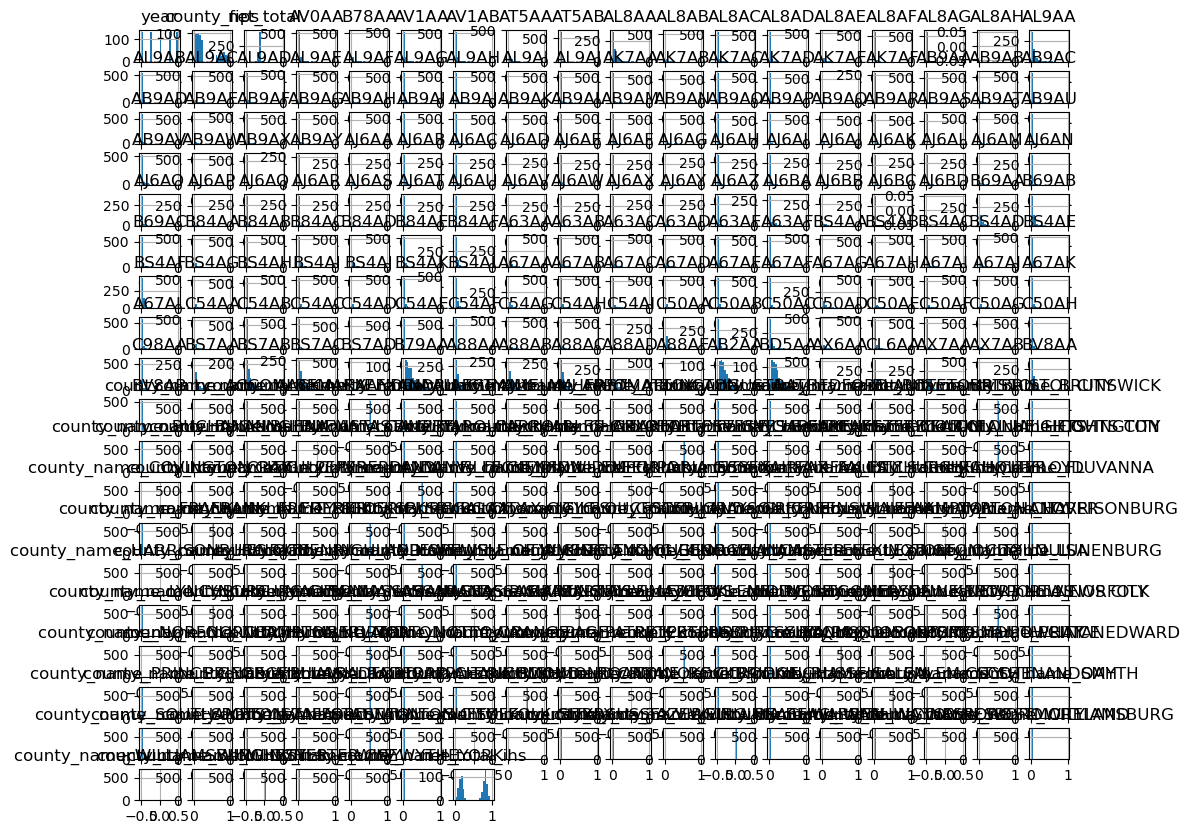

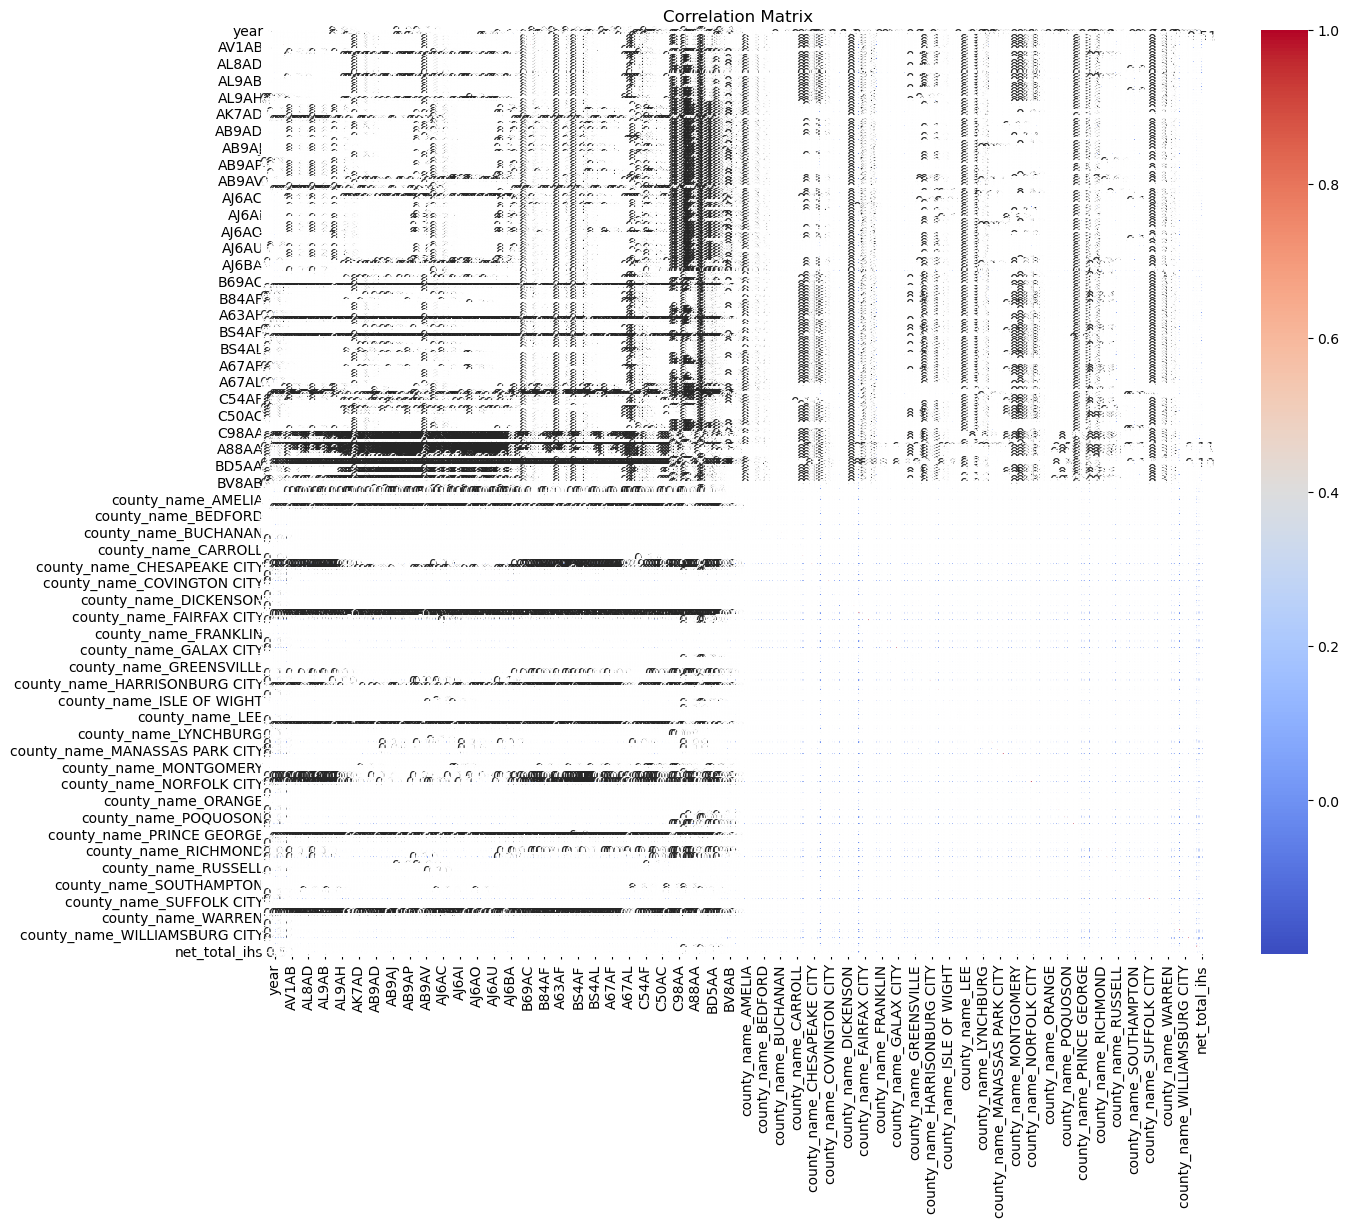

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


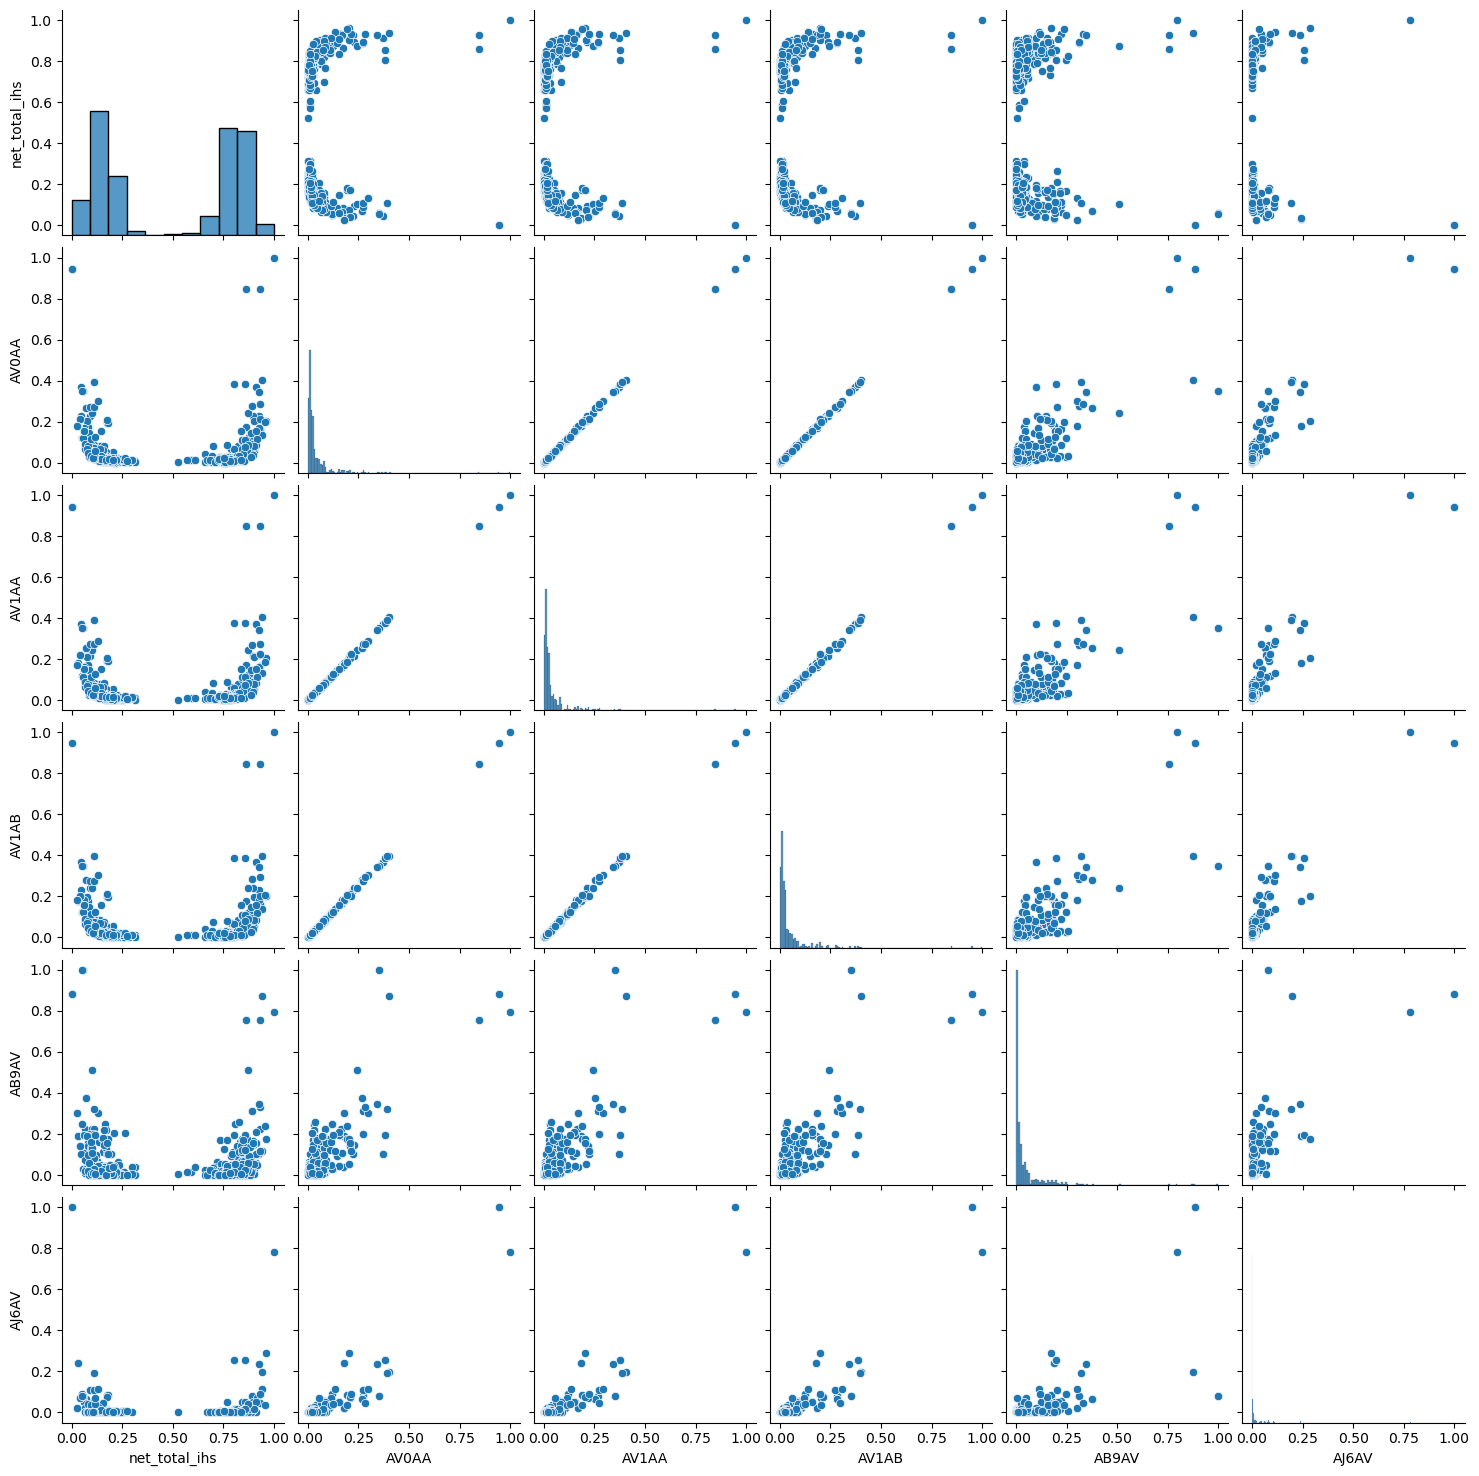

In [57]:
# EDA

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_eda = df_total

df_eda['net_total_ihs'] = np.arcsinh(df_eda['net_total'])

# Normalize the numeric variables
scaler = MinMaxScaler()
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
df_eda[numeric_cols] = scaler.fit_transform(df_eda[numeric_cols])


print(df_eda.head())

# Check for missing values
print(df_eda.isnull().sum())

# Histograms for numeric data to understand distributions
df_eda.hist(figsize=(12, 10), bins=20)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

''' # Boxplots for numerical columns to visualize outliers
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(len(numeric_cols), 1, figsize=(10, len(numeric_cols)*4))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(f'Boxplot for {col}', fontsize=12)
plt.tight_layout()
plt.show()
'''

# Correlation matrix to explore potential relationships
corr_matrix = df_eda.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Pairplot for selected features including the transformed net_total
selected_features = ['net_total_ihs'] + [col for col in df_eda.columns if 'AV' in col][:5]  # example with AV columns
sns.pairplot(df_eda[selected_features])
plt.show()


In [58]:
# Neural network time!
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

y = df_total['net_total'].astype(float)
X = df_total.drop('net_total', axis=1).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

net = Sequential()
#Having 3 layers results in Loss: 218362592.0, Mean Absolute Error (MAE): 6693.912109375, Mean Squared Error (MSE): 218362592.0
net.add(Dense(units=82, activation='relu', input_dim=X_train.shape[1]))
#net.add(Dense(units=32, activation='relu'))
net.add(Dense(units=1, activation='linear'))

net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

net.fit(X_train, y_train, epochs=25, verbose=1, batch_size=50)

# use it to predict testing data
evaluation = net.evaluate(X_test, y_test)

# Extract the evaluation metrics
loss = evaluation[0]
mae = evaluation[1]
mse = evaluation[2]
print("Evaluation metrics:")
print(f"Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Epoch 1/25


/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1285 - mae: 0.3550 - mse: 0.1285  
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1186 - mae: 0.3417 - mse: 0.1186 
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1122 - mae: 0.3311 - mse: 0.1122 
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1043 - mae: 0.3201 - mse: 0.1043 
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0976 - mae: 0.3100 - mse: 0.0976 
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0913 - mae: 0.3001 - mse: 0.0913 
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0848 - mae: 0.2887 - mse: 0.0848 
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0785 - mae: 0.2778 - mse: 0.0785 
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0735 - mae: 0.2689 - mse: 0.0735 
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0692 - mae: 0.2601 - mse: 0.0692 
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0631 - m

In [59]:
# Then use it to predict data from 2020 election since it's closest to current election
predictions_2020 = net.predict(df_2020.drop('net_total', axis=1))

# Sum all the predictions
total_prediction = predictions_2020.sum()

# Check if the total prediction is positive, negative, or zero
if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 330, but received input with shape (32, 329)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 329), dtype=float32)
  • training=False
  • mask=None

In [60]:
#Then evaluate the actual accuracy of the prediction. 
evaluation_2020 = net.evaluate(df_2020.drop('net_total', axis=1), df_2020['net_total'])

# Extract the evaluation metrics
loss_2020 = evaluation_2020[0]
mae_2020 = evaluation_2020[1]
mse_2020 = evaluation_2020[2]
print("Evaluation metrics on 2020 data:")
print(f"Loss: {loss_2020}")
print(f"Mean Absolute Error (MAE): {mae_2020}")
print(f"Mean Squared Error (MSE): {mse_2020}")


2024-05-07 18:47:23.952317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,329], In[1]: [330,82]
	 [[{{node sequential_2_1/dense_5_1/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_2_1/dense_5_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes

  File "/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code

  File "/tmp/ipykernel_761267/2141684951.py", line 2, in <module>

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 425, in evaluate

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 161, in one_step_on_iterator

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 150, in one_step_on_data

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 78, in test_step

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/models/functional.py", line 202, in call

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/models/functional.py", line 592, in call

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 154, in call

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/activations/activations.py", line 47, in relu

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/activations/activations.py", line 99, in static_call

  File "/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [32,329], In[1]: [330,82]
	 [[{{node sequential_2_1/dense_5_1/Relu}}]] [Op:__inference_one_step_on_iterator_11366]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
rf = model.fit(X_train,y_train)

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

In [ ]:
#Now for the linear regression:

In [ ]:
import pandas as pd
df_lr = df_total.copy()
print(df_lr.isna().sum())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

print(df_lr.head())

In [ ]:
for column in df_lr.columns:
    df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
df_lr.fillna(0, inplace=True)

In [ ]:
# Assuming df_total is prepared with necessary preprocessing
y = df_lr['net_total'].astype(float)
X = df_lr.drop('net_total', axis=1).astype(float)

In [ ]:
print(X.isna().sum())
print(y.isna().sum())

In [ ]:
imputer = SimpleImputer(strategy='median')
transformed_data = imputer.fit_transform(df_lr)
df_lr = pd.DataFrame(transformed_data, columns=df_lr.columns)

In [ ]:
print(df_lr.head())

In [ ]:
# Assuming df_total is prepared with necessary preprocessing
y = df_lr[2].astype(float)
X = df_lr.drop(2, axis=1).astype(float)

In [ ]:
print(df_lr.isna().sum())

In [ ]:
df_lr_cleaned = df_lr.dropna()

In [ ]:
print(df_lr.isna().sum())

In [ ]:
# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# the lr model
model = LinearRegression()

In [ ]:
# fitting
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("Model Prediction: " , y_pred)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [ ]:
# evaluating model accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

In [ ]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Clearlt very poor results. This tells us we  have issues with data, where there are too many irrelevant or noisy features. There is also a lack of data scaling and normalization.